## Transformer for Generation from Wikipedia Tiltles

In [9]:
import pandas as pd
import re

In [10]:
df = pd.read_csv('wikipedia_data10K.csv')

In [11]:
!pip install datasets
!pip install transformers
!pip install transformers [torch]
!pip install accelerate -U

ERROR: Invalid requirement: '[torch]'


In [12]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2Tokenizer, GPT2LMHeadModel, pipeline, AutoTokenizer
import datasets
from datasets import load_dataset, list_datasets
from datasets import Dataset
from sklearn.model_selection import train_test_split

In [13]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)
# Reduce the size of the datasets to 3000 samples each
train_df = train_df.sample(n=1000, random_state=42)
val_df = val_df.sample(n=200, random_state=42)

In [16]:
# Create the AutoTokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Define the function to encode your data
def encode(batch):
    return tokenizer([x.strip('\n\r') for x in batch['Text']], truncation=True, padding=True)

# Load and preprocess the dataset
dataset = Dataset.from_pandas(train_df)
processed_dataset = dataset.map(encode, batched=True, batch_size=len(dataset))
processed_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

val_dataset = Dataset.from_pandas(val_df)
processed_val_dataset = val_dataset.map(encode, batched=True, batch_size=len(val_dataset))
processed_val_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

# Load and fine-tune the GPT-2 model

training_args = TrainingArguments(
    output_dir='/content/',
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    logging_steps=10,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=processed_dataset,
    eval_dataset=processed_val_dataset,
)

trainer.train()
trainer.save_model('./trc')

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss
10,3.503500
20,3.370300
30,3.373800
40,3.233600
50,3.238300
60,3.296900


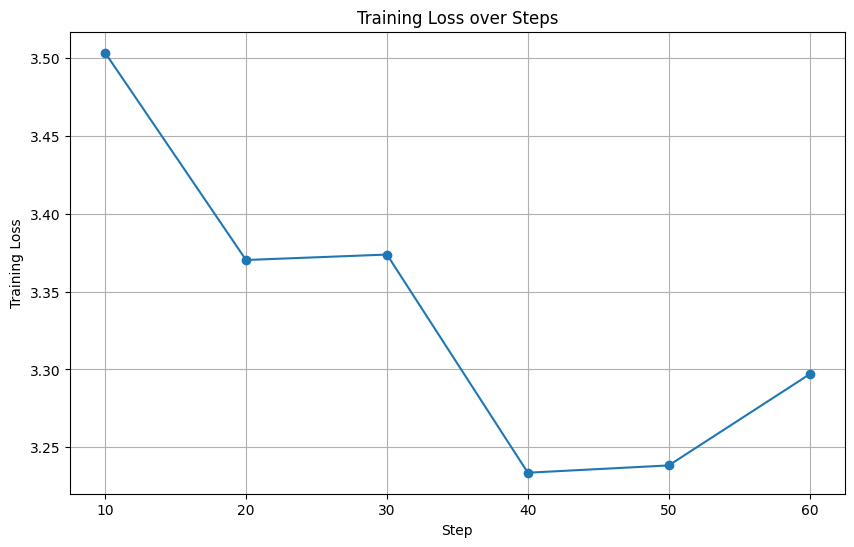

In [29]:
import torch
torch.cuda.memory_summary(device=None, abbreviated=False)

In [24]:
from transformers import pipeline
gpt2 = pipeline('text-generation', model='gpt2')
trc = pipeline('text-generation', model='trc')

print(gpt2('Virtual Box'))
print(trc('Virtual Box'))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Virtual Box –\n\n1-800-745-3000, ext. 7, info@mexicannexology.com\n\n\nIf you still have that missing entry\n\nUse these tips for further information:\n\n-If you want'}]
[{'generated_text': 'Virtual Box (2TB ) is a full size VirtualBox (MBS) which utilizes a dedicated internal microcomputer in a dedicated chassis. Unlike internal VirtualBox™, the box uses no internal USB host computer power, so virtual PCs do not require'}]


In [25]:
print(gpt2('Phoenix Wright: Ace Attorney - Spirit of Justice'))
print(trc('Phoenix Wright: Ace Attorney - Spirit of Justice'))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Phoenix Wright: Ace Attorney - Spirit of Justice A Tale of Two Tails A Tale of Two Titans A Timely Intervention A Trip to Yugoslavia: Director's Cut A Valley Without Wind A Virus Named TOM A Wild Catgirl Appears! A Wizard's Lizard"}]
[{'generated_text': 'Phoenix Wright: Ace Attorney - Spirit of Justice: Ace Attorney - Ultimate Ninja Gaiden Phoenix Wright: Ace Attorney - Ultimate Ninja Gaiden Phoenix Wright: Ace Attorney - Ultimate Ninja Gaiden Phoenix Wright: Ace Attorney - Ultimate Ninja Gaiden Phoenix Wright:'}]


In [26]:
print(gpt2('Ammonium sulfate precipitation'))
print(trc('Ammonium sulfate precipitation'))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Ammonium sulfate precipitation occurs at the base of the graph, and may also occur in other parts of the graph or be associated with different components of the graph, such as a gas-bearing block, an acid-bearing rod or a sulfur'}]
[{'generated_text': 'Ammonium sulfate precipitation in Europe and north-eastern Asia ( ) (from table 1) A map showing the surface level of sulfate in Europe and north-eastern Asia. This precipitation map was collected by M. Lüng'}]


In [27]:
print(gpt2('Heartbeat (British TV series)'))
print(trc('Heartbeat (British TV series)'))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Heartbeat (British TV series)\n\nIris (US TV series)\n\nObituary (TV series)\n\nOn the Beach (UK TV show)\n\nOut Of The Room (US TV series)\n\nOut on'}]
[{'generated_text': 'Heartbeat (British TV series) 2009-04-19 ( Episodes 8–9 ) English voice actor Miki Latham Original episodes 2010-03-11 ( Episodes 8–9 ) French voice actor Maréchal Leche Original'}]
